In [1]:
import sys
import numpy as np
import time
from explauto.utils import rand_bounds
sys.path.append('../')

from cogsci2017.environment.arm_diva_env import CogSci2017Environment
%matplotlib inline
import matplotlib.pyplot as plt

env_audio = CogSci2017Environment(audio=True)
env = CogSci2017Environment()


# Define Vowels and triplets
v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))
#v_a = list(np.log2([800, 1300]))

vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i)
                     
def check_sounds(s_traj, tol=0.2):    
    if s_traj is None:
        return "NNN"
    s1 = s_traj[0]
    s2 = s_traj[24]
    s3 = s_traj[-1]
    
    v1 = "N"
    v2 = "N"
    v3 = "N"
    
    for v in vowels.keys():
        if abs(s1[0]-vowels[v][0]) < tol and abs(s1[1]-vowels[v][1]) < tol:
            v1 = v
        if abs(s2[0]-vowels[v][0]) < tol and abs(s2[1]-vowels[v][1]) < tol:
            v2 = v
        if abs(s3[0]-vowels[v][0]) < tol and abs(s3[1]-vowels[v][1]) < tol:
            v3 = v
    
    sound = v1 + v2 + v3
    
    return sound

../cogsci2017/environment/diva/diva.py:167: RuntimeWarning: invalid value encountered in log2
  formants = log2(transpose(res[self.s_used,:]))



Sound: yNN   Iterations:  [42, 53, 54, 64]
Sound: oNN   Iterations:  [43]
Sound: oNo   Iterations:  [51]
Sound: yoN   Iterations:  [29]
Sound: Nee   Iterations:  [99]
Sound: eNN   Iterations:  [92]
Sound: iNN   Iterations:  [25]
Sound: NyN   Iterations:  [3, 83, 93]
Sound: NNy   Iterations:  [37, 84]
Sound: NiN   Iterations:  [77]

Vowel [ i ] played 2 times
Vowel [ e ] played 2 times
Vowel [ y ] played 10 times
Vowel [ o ] played 3 times


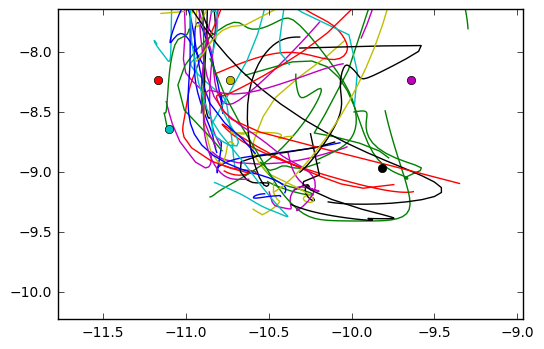

In [3]:
m_list = []
sound_list = []
sound_dict = {}

vowels_dict = {}

for i in range(100):
    m = env.motor_babbling()
    m_list.append(m)
    s_traj = env.diva.update(m[21:], audio=False)
    sound = check_sounds(s_traj)
    sound_list.append(sound)
    if sound_dict.has_key(sound):
        sound_dict[sound] += [i]
    else:
        sound_dict[sound] = [i]
    for v in vowels:
        if v in sound:
            if vowels_dict.has_key(v):
                vowels_dict[v] += [i]
            else:
                vowels_dict[v] = [i]
    plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj])
    
plt.xlim([-np.log2([3500.]), -np.log2([500.])])
plt.ylim([-np.log2([1200.]), -np.log2([200.])])
for v in vowels.keys():
    plt.plot(-vowels[v][1], -vowels[v][0], "o")
    
print
for key in sound_dict.keys():
    if not key == "NNN":
        print "Sound:", key, "  Iterations: ", sound_dict[key]
print
for v in vowels:
    if vowels_dict.has_key(v):
        print "Vowel [", v, "] played", len(vowels_dict[v]), "times"
    
def listen(i):
    print "Playing sound: ", sound_list[i], "of iteration ", i
    m = m_list[i]
    env_audio.diva.update(m[21:])
    
def listen_triplets():
    for key in sound_dict.keys():
        if not (key[0] == "N" or key[1] == "N" or key[2] == "N"):
            for i in sound_dict[key]:
                listen(i)
                time.sleep(1)

In [4]:
listen_triplets()

Playing sound:  uoy of iteration  12


../cogsci2017/environment/diva/diva.py:167: RuntimeWarning: invalid value encountered in log2
  formants = log2(transpose(res[self.s_used,:]))



Sound: NeN   Iterations:  [21, 47]
Sound: NoN   Iterations:  [18]
Sound: ueN   Iterations:  [58]
Sound: NiN   Iterations:  [0, 11, 28]
Sound: NNi   Iterations:  [12, 43]
Sound: NNe   Iterations:  [88]
Sound: yee   Iterations:  [65]
Sound: yNN   Iterations:  [41, 42]
Sound: eyN   Iterations:  [92]
Sound: iNN   Iterations:  [20]
Sound: oNy   Iterations:  [8]
Sound: NyN   Iterations:  [9, 14, 30, 40, 61, 70, 74, 80, 91]
Sound: yNy   Iterations:  [44]
Sound: NNy   Iterations:  [10, 13, 16, 22, 31, 48, 57, 71, 82]
Sound: oNN   Iterations:  [15, 59, 90]
Sound: Nii   Iterations:  [89]
Sound: uNN   Iterations:  [87]

Vowel [ i ] played 7 times
Vowel [ e ] played 6 times
Vowel [ u ] played 2 times
Vowel [ y ] played 24 times
Vowel [ o ] played 5 times


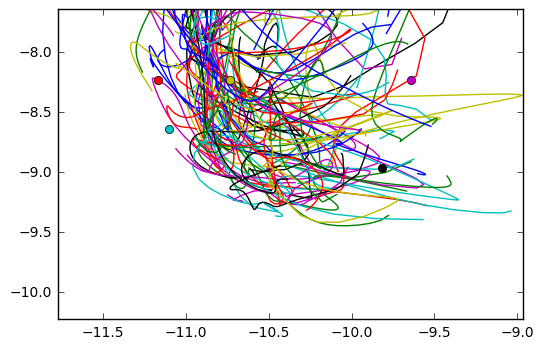

In [2]:
# GOAL BABBLING

from cogsci2017.learning.supervisor import Supervisor

config = dict(m_mins=env.conf.m_mins,
             m_maxs=env.conf.m_maxs,
             s_mins=env.conf.s_mins,
             s_maxs=env.conf.s_maxs)

agent = Supervisor(config, explo_noise=0.1)
n_motor_babbling = 200

m_list = []
sound_list = []
sound_dict = {}

vowels_dict = {}


# Active Model Babbling
for i in range(100):
    if i < n_motor_babbling:
        m = agent.motor_babbling(audio=True)
    else:
        context = [0.]*10
        m = agent.produce(context)
    s = env.update(m)
    
    agent.perceive(s)
    
    m_list.append(m)
    s_traj = env.diva_traj
    if s_traj is not None:

        sound = check_sounds(s_traj)
        sound_list.append(sound)
        if sound_dict.has_key(sound):
            sound_dict[sound] += [i]
        else:
            sound_dict[sound] = [i]
        for v in vowels:
            if v in sound:
                if vowels_dict.has_key(v):
                    vowels_dict[v] += [i]
                else:
                    vowels_dict[v] = [i]
        plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj])
    
plt.xlim([-np.log2([3500.]), -np.log2([500.])])
plt.ylim([-np.log2([1200.]), -np.log2([200.])])
for v in vowels.keys():
    plt.plot(-vowels[v][1], -vowels[v][0], "o")
    
print
for key in sound_dict.keys():
    if not key == "NNN":
        print "Sound:", key, "  Iterations: ", sound_dict[key]
print
for v in vowels:
    if vowels_dict.has_key(v):
        print "Vowel [", v, "] played", len(vowels_dict[v]), "times"
    
def listen(i):
    print "Playing sound: ", sound_list[i], "of iteration ", i
    m = m_list[i]
    env_audio.diva.update(m[21:])
    
def listen_triplets():
    for key in sound_dict.keys():
        if not (key[0] == "N" or key[1] == "N" or key[2] == "N"):
            for i in sound_dict[key]:
                listen(i)
                time.sleep(1)

In [47]:
listen_triplets()

Playing sound:  yee of iteration  57


(array([-10.22881869]), array([-7.64385619]))

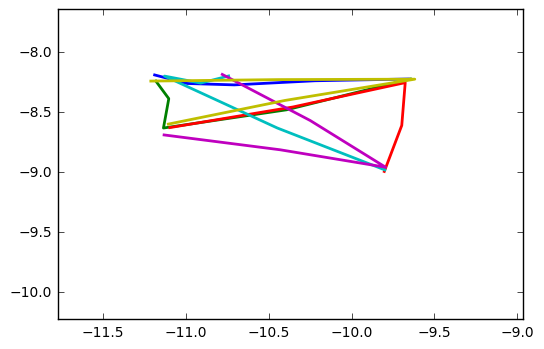

In [3]:
human_sounds = ["uyi", "ieu", "euo", "oiy", "yoe", "eui"]

def compute_s_sound(sound):
    s1 = vowels[sound[0]]
    s2 = [(vowels[sound[0]][0] + vowels[sound[1]][0]) / 2., (vowels[sound[0]][1] + vowels[sound[1]][1]) / 2.]
    s3 = vowels[sound[1]]
    s4 = [(vowels[sound[1]][0] + vowels[sound[2]][0]) / 2., (vowels[sound[1]][1] + vowels[sound[2]][1]) / 2.]
    s5 = vowels[sound[2]]
    rdm = 0.05 * (2.*np.random.random((1,10))[0] - 1.)
    return list(rdm + np.array([f[0] for f in [s1, s2, s3, s4, s5]] + [f[1] for f in [s1, s2, s3, s4, s5]]))


human_sounds_traj = dict()
for hs in human_sounds:
    human_sounds_traj[hs] = compute_s_sound(hs)
    plt.plot(- np.array(human_sounds_traj[hs][5:]), -np.array(human_sounds_traj[hs][:5]), lw=2)
    
plt.xlim([-np.log2([3500.]), -np.log2([500.])])
plt.ylim([-np.log2([1200.]), -np.log2([200.])])


In [30]:
# IMITATE AND EXPLORE AND LEARN

def train_imitation(sound_id=0, iterations=100, explo_noise=0.1):
    hs = human_sounds[sound_id]
    
    sigma = np.array([explo_noise]*28)
    agent.modules["mod13"].sm.sigma_expl = sigma

    m = agent.modules["mod13"].inverse(np.array(env.get_current_context() + human_sounds_traj[hs]), explore=False) 
    s = env.update([0.]*21 + list(m))
    s_traj = env.diva_traj
    error_before_imitation = np.linalg.norm(np.array(human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))

    print "error before imitation for sound", hs, error_before_imitation


    for i in range(iterations):
        #print env.get_current_context()
        m = agent.modules["mod13"].inverse(np.array(env.get_current_context() + human_sounds_traj[hs]), explore=True) 
        agent.m = [0.]*21 + list(m)
        s = env.update(agent.m)
        agent.perceive(s)
        s_traj = env.diva_traj

        sound = check_sounds(s_traj)

        # Error
        error = np.linalg.norm(np.array(human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[::10]] + [f[1] for f in s_traj[::10]]))
        #print "current error", error

        plt.plot(-s_traj[0][1], -s_traj[0][0], "ok", alpha=0.2)
        plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], alpha=0.2)

    # Human Sound
    plt.plot(- np.array(human_sounds_traj[hs][5:])[0], -np.array(human_sounds_traj[hs][:5][0]), "ok")
    plt.plot(- np.array(human_sounds_traj[hs][5:]), -np.array(human_sounds_traj[hs][:5]), lw=3)

    # Best Sound
    m = agent.modules["mod13"].inverse(np.array(env.get_current_context() + human_sounds_traj[hs]), explore=False) 
    s = env_audio.update([0.]*21 + list(m))
    s_traj = env_audio.diva_traj
    #print "best", s_traj
    plt.plot(-s_traj[0][1], -s_traj[0][0], "ok")
    plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], lw=5)
    # Error
    error = np.linalg.norm(np.array(human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))
    print "best error", error

    plt.xlim([-np.log2([3500.]), -np.log2([500.])])
    plt.ylim([-np.log2([1200.]), -np.log2([100.])])

error before imitation for sound eui 0.910519507784
best error 0.91033247094


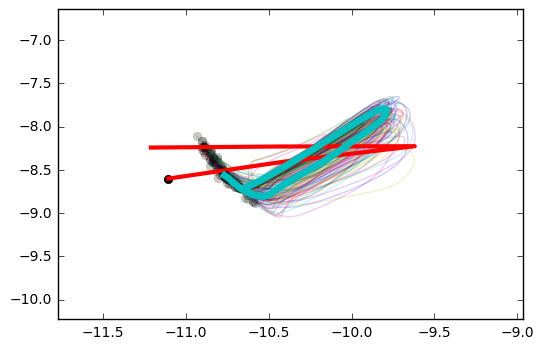

In [62]:
train_imitation(5, iterations=100, explo_noise=0.1)